# import

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from rastermap import Rastermap

cmap = plt.cm.get_cmap('viridis_r')

import os
import scipy.io
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import pearsonr, zscore
from scipy.io import savemat
import random
import utils
from sklearn.decomposition import PCA
plt.rcParams['axes.facecolor'] = 'white'
outcome_list = ['Hit', 'Miss', 'FA', 'CR']
mouse_names = ['jl009', 'fz017', 'fz009', 'fz006', "se063"] # se063 is passive animal
data_paths = ["Z:/Jenni/jl009/behavimaging.mat",
             "W:/Jenni/fz017/behavimaging.mat",
             "Y:/Jenni/fz009/behavimaging.mat",
             "Y:/sarah/fz006/behavimaging.mat",
             "Y:/sarah/se063/behavimaging.mat"]
disks = ['Z', 'W', 'Y', 'Y', 'Y']

mouse_id = 0
thresh = 0.05 # correlation threshold for selecting important axons
mouse_name = mouse_names[mouse_id]
disk = disks[mouse_id]

data_path = "data/{}_behavimaging.mat".format(mouse_name)
mat = scipy.io.loadmat(data_path)
data = mat['behavimaging']
nBlocks = data.shape[-1]
nDays = data[0, -1]['day'][0][0]

valid_days = []
for day in range(1, nDays+1):
    iblocks = utils.daily_blocks(data, day)
    if len(iblocks)>0:
        valid_days.append(day)
        
# cmap = plt.cm.get_cmap('viridis_r')
valid_days_all = [[1, 2, 3, 5, 6, 7, 8, 9, 15],
                  [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26],
                  [1,2,5,11]]
    
# day_groups_all = [[[1,2,3], [5,6], [7,8,9], [15]], 
#                  [[1,2,4,5], [6,7,8,9,10], [11, 12,14,15], [17,23], [24,25,26]],
#                  [[1,2], [5], [11]], # 15
#                  [[1,2,3,4,5], [6,9,10], [11,15]]]

# to unify with Jenni's ICAC plots
day_groups_all = [[[1,2,3,5,6], [7,8,9], [15]], 
                 [[1,2,4,5,6,7,8,9,10], [11,12,14,15], [17,23,25,26]],
                 [[1,2], [5], [11]]]
day_groups_label = ['early', 'middle', 'late']
day_groups = day_groups_all[mouse_id]

# decoding from all

In [48]:
avg_weight = True
n_first_frame = 45
all_mice_acc = []
for mouse_id in range(3):
    mouse_name = mouse_names[mouse_id]
    disk = disks[mouse_id]

    data_path = "data/{}_behavimaging.mat".format(mouse_name)
    mat = scipy.io.loadmat(data_path)
    data = mat['behavimaging']
    blocks = []
    valid_days = []
    for day in range(1, nDays+1):
        iblocks = utils.daily_blocks(data, day)
        if len(iblocks)>0:
            valid_days.append(day)

    if mouse_name == 'jl009':
        valid_days = [1, 2, 3, 5, 6, 7, 8, 9, 15]
    if mouse_name == 'fz017':
        valid_days = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 23, 24, 25, 26]

    all_acc = np.zeros((3, len(valid_days))) # prediction acc with all activities in the time window
    pb_acc = np.zeros((3, len(valid_days))) 
    pre_window=45

    stim_weights = []
    prelick_weights = []
    postlick_weights = []
    for i, day in enumerate(valid_days):
        print('-------------------day {}---------------------'.format(day))
        print('******** predict with activities in [T-{}, T+45]'.format(pre_window))
        iblocks = utils.daily_blocks(data, day)
        if len(iblocks)>0:
            daily_cues = []
            daily_outcomes = []
            daily_responses = []
            daily_firstlicks = []
            daily_alllicks = []
            valid = True
            for j in iblocks:
                block = data[0, j]
                # normalize doesn't have much effect on the result, so set it to False
                cues, outcomes, firstlicks, stim_resp, alllicks = utils.block_stim_evoke_response(block, window=[pre_window, 45], normalize=True, dff=False)
                if len(daily_responses) > 0:
                    if daily_responses[0].shape != stim_resp.shape:
                        valid = False
                if valid == True:
                    daily_cues.append(cues)
                    daily_outcomes.append(outcomes)
                    daily_responses.append(stim_resp)
                    daily_firstlicks.append(firstlicks)
                    daily_alllicks.append(alllicks)

            daily_cues = np.hstack(daily_cues)
            daily_outcomes = np.hstack(daily_outcomes)
            daily_responses = np.vstack(daily_responses)
            daily_alllicks = np.vstack(daily_alllicks)

        nanflag = np.sum(np.isnan(daily_responses.reshape(len(daily_responses), -1)), axis=1)
        inotnan = np.where(nanflag==0)
        daily_responses = daily_responses[inotnan]
        daily_cues = daily_cues[inotnan]
        daily_outcomes = daily_outcomes[inotnan]
        daily_alllicks = daily_alllicks[inotnan]

        
        # spks = daily_responses[:, :, :pre_window]
        spks = daily_responses.copy()
        NT, NA, NF = spks.shape
        if avg_weight:
            spks = spks.mean(axis=1)
        else:
            spks = spks.reshape(spks.shape[0], -1)

        prelick = (np.sum(daily_alllicks[:, (pre_window-30):(pre_window-15)], axis=1) > 0)
        prelick = np.multiply((prelick == 1), 1)
        if (np.mean(prelick) == 0) or (np.mean(prelick) == 1):
            acc, weights = 0.5, False
        else:
            acc, weights = utils.classifier(spks, prelick)
            if not avg_weight: weights = weights.reshape((NA, NF))
        all_acc[2, i] = acc
        print('accuracy predicting prelick on test set: ', acc)
        prelick_weights.append(weights)
    all_mice_acc.append(all_acc[2])

-------------------day 1---------------------
******** predict with activities in [T-45, T+45]
valid samples: 200
accuracy predicting prelick on test set:  0.764179104477612
-------------------day 2---------------------
******** predict with activities in [T-45, T+45]
valid samples: 254
accuracy predicting prelick on test set:  0.8011764705882353
-------------------day 3---------------------
******** predict with activities in [T-45, T+45]
valid samples: 228
accuracy predicting prelick on test set:  0.8171052631578947
-------------------day 5---------------------
******** predict with activities in [T-45, T+45]
valid samples: 198
accuracy predicting prelick on test set:  0.8181818181818181
-------------------day 6---------------------
******** predict with activities in [T-45, T+45]
valid samples: 290
accuracy predicting prelick on test set:  0.7927835051546392
-------------------day 7---------------------
******** predict with activities in [T-45, T+45]
valid samples: 146
accuracy pre

In [59]:
# group acc by day group
all_acc_group = []
for i in range(len(day_groups)):
    all_acc_group.append([])
    for mouse_id in range(3):
        all_accs = all_mice_acc[mouse_id]
        day_group = day_groups_all[mouse_id]
        valid_days = valid_days_all[mouse_id]
        # find the index of days in valid_days that are in the ith day group
        ind = np.where(np.isin(valid_days, day_group[i]))[0]
        print(ind)
        all_acc_group[i].append(all_accs[ind])
    all_acc_group[i] = np.hstack(all_acc_group[i])
    print(len(all_acc_group[i]))

[0 1 2 3 4]
[0 1 2 3 4 5 6 7 8]
[0 1]
16
[5 6 7]
[ 9 10 11 12]
[2]
8
[8]
[13 14 16 17]
[3]
6


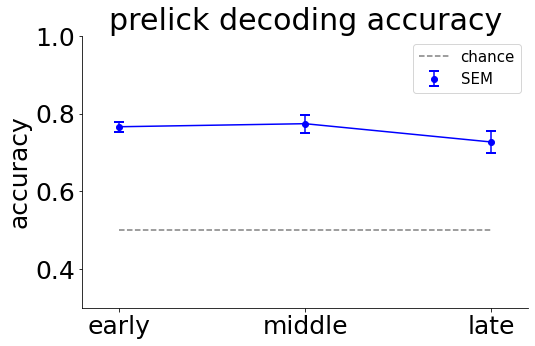

In [80]:
# plot average accuracy of each day groups
accs = np.zeros(len(day_groups))
stds = np.zeros(len(day_groups))
sems = np.zeros(len(day_groups))
for i in range(len(day_groups)):
    # find the index of days in valid_days that are in the ith day group
    acc = all_acc_group[i]
    accs[i] = np.mean(acc)
    stds[i] = np.std(acc)
    sems[i] = stds[i] / np.sqrt(len(acc))
colors = np.array(["green", "blue"])
x = np.arange(1, len(day_groups)+1)
plt.figure(figsize=(8, 5))
plt.rcParams['font.size'] = 25
dp_nonzero = np.where(dptrue>0)
dr_nonzero = np.where(drtrue>0)
plt.plot(x, accs, color='blue')
# plot std as error bar
plt.errorbar(x, accs, yerr=sems, fmt='o', color='blue', capsize=5, capthick=2, label='SEM')
plt.plot(x, np.ones(x.shape)*0.5, label='chance', linestyle='--', color='gray')
plt.title('prelick decoding accuracy')
plt.xticks(x, day_groups_label)
# plt.xlabel('day')
plt.ylabel('accuracy')
plt.xlim([x.min()-0.2, x.max()+0.2])
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylim([0.3, 1])
plt.legend(fontsize=15)
# save figure as svg file
plt.savefig("figures/prelick_decoding_accuracy_all.svg", format="svg")
